# Lab 1.2 - Manipulating Abstractions via ArcPy
### Luke Zaruba
### GIS 5572: ArcGIS II
### 2023-02-16

In [1]:
import arcpy
import os
import matplotlib.pyplot as plt

## ArcPy

In the following code blocks, ArcPy will be used to perform common geospatial manipulation tasks, ranging from high-level tasks to constructing files from GIS primitives. ArcPy is an Esri Python library that acts as an interface which simplifies the bulk of the geoprocessing operations (and much more) that power ArcGIS.

For more information on [ArcPy](https://pro.arcgis.com/en/pro-app/latest/arcpy/get-started/what-is-arcpy-.htm), check out the documentation.

### 0. Creating a File Geodatabase

In order to create feature classes, we first need a file geodatabase to store the feature classes. If we wanted to save the new files as shapefiles instead, we could just add *.shp* to the output file name and have the output path be a folder rather than a *.gdb* file

In [2]:
# Check if directory exists and create if not
fullPath = '../Outputs/Example.gdb'
outputDir, gdbName = os.path.split(fullPath)

if not os.path.exists(outputDir):
    os.mkdir(outputDir)

# Create FGDB
arcpy.management.CreateFileGDB(outputDir, gdbName)

<Result '../Outputs\\Example.gdb'>

### 1. Create an Empty Feature Class

In this example, an empty feature class is being created from scratch using ArcPy.

In [3]:
# Create empty FC
arcpy.management.CreateFeatureclass(fullPath, "empty")

<Result 'c:\\gitFiles\\GIS5572\\Lab1\\Outputs\\Example.gdb\\empty'>

### 2. Create a Feature Class with Points

In this example, a feature class is being created from scratch using ArcPy and points are being added into it.

In [4]:
# Create FC
arcpy.management.CreateFeatureclass(fullPath, 'myCities', 'POINT')

# Input Data
sr = arcpy.SpatialReference(4326)

myCityGeoms = [arcpy.PointGeometry(i, sr) for i in [arcpy.Point(-93.2650, 44.9778), arcpy.Point(-92.1005, 46.7867), arcpy.Point(-92.4802, 44.0121)]]

# Create Insert Cursor
with arcpy.da.InsertCursor(os.path.join(fullPath, 'myCities'), ['SHAPE@']) as curs:
    for row in myCityGeoms:
        curs.insertRow(row)

# Delete Cursor
del curs

### 3. Create a Feature Class with Lines 
In this example, a shapefile is being created from scratch using ArcPy and a single line feature is being added into it.

In [5]:
# Create FC
arcpy.management.CreateFeatureclass(fullPath, 'myLine', 'POLYLINE')

# Input Data
sr = arcpy.SpatialReference(4326)

myLine = arcpy.Polyline(arcpy.Array([arcpy.Point(-93.2650, 44.9778), arcpy.Point(-92.1005, 46.7867), arcpy.Point(-92.4802, 44.0121)]), sr)

# Create Insert Cursor
curs = arcpy.da.InsertCursor(os.path.join(fullPath, 'myLine'), ['SHAPE@'])

# Insert Values
curs.insertRow([myLine])

# Delete Cursor
del curs

### 4. Create a Feature Class with Polygons 
In this example, a feature class is being created from scratch using ArcPy and a single polygon feature is being added into it.

In [6]:
# Create FC
arcpy.management.CreateFeatureclass(fullPath, 'myPolygon', 'POLYGON')

# Input Data
sr = arcpy.SpatialReference(4326)

myPolygon = arcpy.Polygon(arcpy.Array([arcpy.Point(-93.2650, 44.9778), arcpy.Point(-92.1005, 46.7867), arcpy.Point(-92.4802, 44.0121)]), sr)

# Create Insert Cursor
curs = arcpy.da.InsertCursor(os.path.join(fullPath, 'myPolygon'), ['SHAPE@'])

# Insert Values
curs.insertRow([myPolygon])

# Delete Cursor
del curs

### 5. View Each Row in an Attribute Table for a Feature Class
In this example, we will use the point feature class created in step 2 and examine its contents.

In [7]:
# Create Search Cursor
with arcpy.da.SearchCursor(os.path.join(fullPath, 'myCities'), ['SHAPE@']) as curs:
    for row in curs:
        print(row)

(<PointGeometry object at 0x202ecc7f6a0[0x202eccf6390]>,)
(<PointGeometry object at 0x202f6789190[0x202f6789de0]>,)
(<PointGeometry object at 0x202ecc7f6a0[0x202eccf6390]>,)


### 6. View Each Geometry Object for a Feature Class
In this example, we will view each feature in a Matplotlib plot.

In [8]:
# Create empty point list
pointList = []

# Get geom values
with arcpy.da.SearchCursor(os.path.join(fullPath, 'myCities'), ['SHAPE@']) as curs:
    for row in curs:
        x, y = row[0].centroid.X, row[0].centroid.Y
        pointList.append((x, y))

pointList

[(-93.2650146484375, 44.9779052734375),
 (-92.10052490234375, 46.78668212890625),
 (-92.480224609375, 44.0120849609375)]

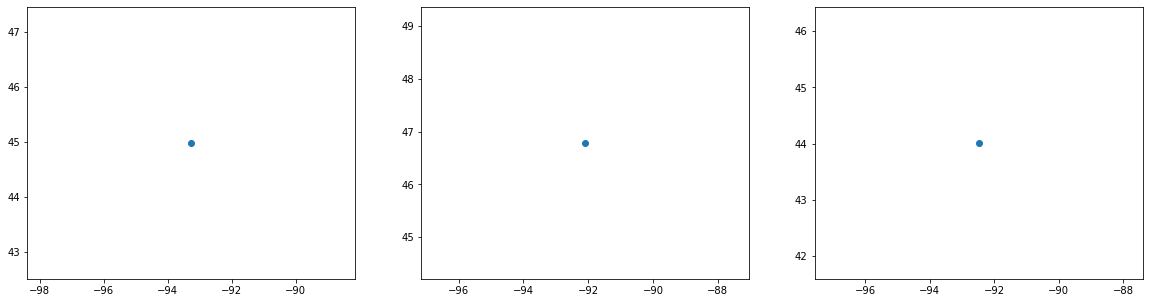

In [9]:
# Setup MPL
fig, ax = plt.subplots(ncols=len(pointList), figsize=(20, 5))

# Loop through list and add points to display
for i, (x, y) in enumerate(pointList):
    ax[i].scatter(x, y)

# Display
plt.show()

### 7. Summarize the Contents of a Feature Class
In this example, we will use the feature class that we used in the previous step and summarize its contents.

In [10]:
# Summarize FC Contents
desc = arcpy.Describe(os.path.join(fullPath, 'myCities'))

print("Fields: " + str([i.name for i in desc.fields]) + "\n" + "Type: " + desc.shapeType + "\n")

Fields: ['OBJECTID', 'Shape']
Type: Point



### 8. Export to Shapefile
In this example, we will export a feature class to a shapefile using ArcPy.

In [11]:
# Export to Shapefile
arcpy.conversion.FeatureClassToFeatureClass(os.path.join(fullPath, 'myCities'), os.path.abspath(outputDir), "myCities.shp")

<Result 'c:\\gitFiles\\GIS5572\\Lab1\\Outputs\\myCities.shp'>

### 9. Export to Geodatabase
Similarly to Shapefiles, Geodatabases are a file format created by Esri, except they are not as easy to access and manipulate with open-source tools as Shapefiles are.

By looking at Fiona's supported drivers (as seen in the code block below) we can see a driver called *OpenFileGDB* with a value of *r*. This means that with Fiona, we can actually read in File Geodatabases, but we can not append or write to them, as we can with Shapefiles (seen in the driver called *ESRI Shapefile* with values *raw* for read, append, and write, respectively).

In [12]:
# Create New FGDB
arcpy.management.CreateFileGDB(outputDir, "Export.gdb")

# Export to GDB
arcpy.conversion.FeatureClassToGeodatabase(os.path.join(os.path.abspath(fullPath), 'myCities'), os.path.join(os.path.abspath(outputDir), "Export.gdb"))

<Result 'c:\\gitFiles\\GIS5572\\Lab1\\Outputs\\Export.gdb'>

### Let's Check Out the Results!

The following code blocks use Shell Script, as VSCode refers to it (which in my case is Powershell), to check if the outputs are actually there and then deletes them so that we can use other methods to recreate the same files.

In [13]:
pwd

'c:\\gitFiles\\GIS5572\\Lab1\\Notebooks'

In [14]:
cd ../Outputs

c:\gitFiles\GIS5572\Lab1\Outputs


In [15]:
ls

 Volume in drive C is Windows
 Volume Serial Number is 4A73-34D5

 Directory of c:\gitFiles\GIS5572\Lab1\Outputs

02/15/2023  07:59 PM    <DIR>          .
02/15/2023  07:59 PM    <DIR>          ..
02/15/2023  07:59 PM    <DIR>          Example.gdb
02/15/2023  07:59 PM    <DIR>          Export.gdb
02/15/2023  07:59 PM                 5 myCities.cpg
02/15/2023  07:59 PM                87 myCities.dbf
02/15/2023  07:59 PM               172 myCities.sbn
02/15/2023  07:59 PM               124 myCities.sbx
02/15/2023  07:59 PM               184 myCities.shp
02/15/2023  07:59 PM             3,885 myCities.shp.xml
02/15/2023  07:59 PM               124 myCities.shx
               7 File(s)          4,581 bytes
               4 Dir(s)  303,830,863,872 bytes free


All the shapefiles are in the folder, so it looks like everything worked good!